In [1]:
using Pkg
Pkg.activate(".");

  Activating new environment at `C:\Users\User\Documents\Graduate Files\Physics 215\Session 01\Project.toml`


# KR1: Using ```@code_*```

Let us use ```@code_*``` to examine the operation ```1 + 1```. For this exercise, we will use the ```@code_native```, ```@code_typed```, ```@code_warntype```, ```@code_llvm```, and ```@code_lowered``` macros, as shown in [Julia's Interactive Utilities](https://docs.julialang.org/en/v1/stdlib/InteractiveUtils/). As with the other Julia methods, these macros "evaluates the arguments to the function, determines their types", then call the corresponding non-```@``` macro.

## ```@code_native```

According to [Julia's Interactive Utilities](https://docs.julialang.org/en/v1/stdlib/InteractiveUtils/#InteractiveUtils.code_native), the ```code_native``` macro shows us the native assembly instructions generated by Julia to run a certain function with the given type.

To see this in action, let us use it by evaluating ```1 + 1```, and comparing it when we use ```1.0 + 1.0``` instead

In [2]:
@code_native 1 + 1

	.text
; ┌ @ int.jl:87 within `+'
	pushq	%rbp
	movq	%rsp, %rbp
	leaq	(%rcx,%rdx), %rax
	popq	%rbp
	retq
	nopw	(%rax,%rax)
; └


In [3]:
@code_native 1.0 + 1.0

	.text
; ┌ @ float.jl:326 within `+'
	pushq	%rbp
	movq	%rsp, %rbp
	addsd	%xmm1, %xmm0
	popq	%rbp
	retq
	nopw	(%rax,%rax)
; └


Notice that the bulk of the output for both inputs are the same, except the second line. When we pass ```1 + 1``` onto ```@code_native```, Julia recognizes that we are adding integers to each other, while float, when we pass ```1.0 + 1.0```. After this, everything is the same. Looking back at what ```@code_native``` does, we can say that the rest of the output is the native assembly instructions in order to execute addition. Nice!

But what do you think happens when we add an integer with a float? Let's execute this.

In [4]:
@code_native 1.0 + 1

	.text
; ┌ @ promotion.jl:321 within `+'
	pushq	%rbp
	movq	%rsp, %rbp
; │┌ @ promotion.jl:292 within `promote'
; ││┌ @ promotion.jl:269 within `_promote'
; │││┌ @ number.jl:7 within `convert'
; ││││┌ @ float.jl:94 within `Float64'
	cvtsi2sd	%rdx, %xmm1
; │└└└└
; │ @ promotion.jl:321 within `+' @ float.jl:326
	addsd	%xmm1, %xmm0
; │ @ promotion.jl:321 within `+'
	popq	%rbp
	retq
	nop
; └


Notice now that instead of interpreting the argument types in the second line, Julia now executes a series of protocols in order to make both inputs the same data type -- in this case, a float type, then proceeds to sum the two numbers.

## ```@code_typed```

According to [Julia's Essentials](https://docs.julialang.org/en/v1/base/base/#Base.code_typed), the ```@code_typed``` macro "returns an array of type-inferred lowered form (IR) for the methods matching the given function and type signature." Let us try to enlighten ourselves on what that means by doing our operation.

In [5]:
@code_typed 1 + 1

CodeInfo(
1 ─ %1 = Base.add_int(x, y)::Int64
└──      return %1
) => Int64

In [6]:
@code_typed 1.0 + 1.0

CodeInfo(
1 ─ %1 = Base.add_float(x, y)::Float64
└──      return %1
) => Float64

Notice that when we pass ```1 + 1``` and ```1.0 + 1.0``` onto the macro, we get the data type of the result of the expression -- an ```Int64``` for ```1 + 1``` and ```Float64``` for ```1.0 + 1.0```. This probably means that when we pass a function involving an array, this macro will operate the function, and give us an array containing the data types that is returned after the function was evaluated.

What happens now when we mix these two together? Note that when we used ```@code_native``` on ```1.0 + 1```, the native assembly instructions told us that Julia made sure that it was adding variables of the same data type. So does this mean that the macro will output a ```Float64```?

In [7]:
@code_typed 1.0 + 1

CodeInfo(
1 ─ %1 = Base.sitofp(Float64, y)::Float64
│   %2 = Base.add_float(x, %1)::Float64
└──      return %2
) => Float64

So it did! This means that Julia does what the native assembly instruction tells it to do, and outputs the corresponding result with the instructed data type!

## ```@code_warntype```

According to [Julia's Interactive Utilities](https://docs.julialang.org/en/v1/stdlib/InteractiveUtils/#InteractiveUtils.code_warntype) "prints lowered and type-inferred ASTs for the methods matching the given function and type signature." A little search tells us that these ASTs, or [Abstract Syntax Tree](https://deepsource.io/glossary/ast/) is akin to atree representation of the code that the computer is trying to run.

To see how this really works, let us see what it does when we pass our operation. Since we have more insight on how Julia behaves with ```@code_native``` and ```@code_typed```, we can omit passing ```1.0 + 1.0``` onto our function.

In [8]:
@code_warntype 1 + 1

Variables
  #self#::Core.Const(+)
  x::Int64
  y::Int64

Body::Int64
1 ─ %1 = Base.add_int(x, y)::Int64
└──      return %1


Notice that since our function is just simple addition, then our tree is just one stage. To see how Julia can handle more 'complex' functions, let us define a function ```euclid_gcd(a, b)``` that finds the greatest common divisors between two integers ```a``` and ```b```.

In [9]:
function euclid_gcd(a::Int64, b::Int64)
    if b == 0
        return a
    end
    return euclide_gcd(b, a%b)
end;

Now, passing this function to ```@code_warntype```, with $a=42$ and $b=7$, we get

In [10]:
@code_warntype euclid_gcd(42, 7)

Variables
  #self#::Core.Const(euclid_gcd)
  a::Int64
  b::Int64

Body::Any
1 ─ %1 = (b == 0)::Bool
└──      goto #3 if not %1
2 ─      return a
3 ─ %4 = (a % b)::Int64
│   %5 = Main.euclide_gcd(b, %4)::Any
└──      return %5


Now we see that ```@code_warntype``` essentially gives us a pseudocode-like version of our code. The left hand side shows us the steps, while the right shows us what Julia is trying to do in evaluating the code, which is a nice way to debug code!

## ```@code_llvm```

According to [Julia's Interactive Utilities](https://docs.julialang.org/en/v1/stdlib/InteractiveUtils/#InteractiveUtils.code_llvm), the ```@code_llvm``` prints the LLVM itcodes generated for running the passed method. As was discussed in class, Julia's "compilaion infrastructure is built on top of [LLVM](https://llvm.org/)," which is a "collection of modular and resuable compiled and toolchain technologies." This way, Julia may be able to compile and run these codes faster and more efficiently.

Let us pass ```1 + 1``` and ```euclid_gcd(a, b)```  onto this to see how this works.

In [11]:
@code_llvm 1 + 1

;  @ int.jl:87 within `+'
; Function Attrs: uwtable
define i64 @"julia_+_1633"(i64 signext %0, i64 signext %1) #0 {
top:
  %2 = add i64 %1, %0
  ret i64 %2
}


In [12]:
@code_llvm euclid_gcd(42, 7)

;  @ In[9]:1 within `euclid_gcd'
; Function Attrs: uwtable
define nonnull {}* @julia_euclid_gcd_1648(i64 signext %0, i64 signext %1) #0 {
top:
  %2 = alloca [2 x {}*], align 8
  %gcframe4 = alloca [5 x {}*], align 16
  %gcframe4.sub = getelementptr inbounds [5 x {}*], [5 x {}*]* %gcframe4, i64 0, i64 0
  %.sub = getelementptr inbounds [2 x {}*], [2 x {}*]* %2, i64 0, i64 0
  %3 = bitcast [5 x {}*]* %gcframe4 to i8*
  call void @llvm.memset.p0i8.i32(i8* nonnull align 16 dereferenceable(40) %3, i8 0, i32 40, i1 false)
  %4 = call {}*** inttoptr (i64 41153232 to {}*** ()*)() #7
;  @ In[9]:2 within `euclid_gcd'
  %5 = bitcast [5 x {}*]* %gcframe4 to i64*
  store i64 12, i64* %5, align 16
  %6 = getelementptr inbounds [5 x {}*], [5 x {}*]* %gcframe4, i64 0, i64 1
  %7 = bitcast {}*** %4 to i64*
  %8 = load i64, i64* %7, align 8
  %9 = bitcast {}** %6 to i64*
  store i64 %8, i64* %9, align 8
  %10 = bitcast {}*** %4 to {}***
  store {}** %gcframe4.sub, {}*** %10, align 8
  switch i64 %1, lab

Notice that passing them to the ```@code_llvm``` macro gives us a string of LLVM codes (*needs citation*). Nice!

## ```@code_lowered```

According to [Julia's Essentials](https://docs.julialang.org/en/v1/base/base/#Base.code_lowered), this macro "returns an array of the lowered form (IR)" for the methods passed on the macro.

While this is vague, let us pass ```1 + 1``` and ```euclid_gcd(a, b)``` on it to see how it works.

In [13]:
@code_lowered 1 + 1

CodeInfo(
1 ─ %1 = Base.add_int(x, y)
└──      return %1
)

In [14]:
@code_lowered euclid_gcd(42, 7)

CodeInfo(
1 ─ %1 = b == 0
└──      goto #3 if not %1
2 ─      return a
3 ─ %4 = a % b
│   %5 = Main.euclide_gcd(b, %4)
└──      return %5
)

And so we see that this macro is like ```@code_warntype``` except not showing the variables and data types involved in evaluating the function. Nice!

# KR2: Determine constants in codes

Let us now show how Julia determines constants in our codes. To facilitate this, let us define a function ```area(r)``` to calculate the area of a circle with radius $r$.

In [15]:
function area(r::Float64)
    return pi*r^2
end;

where ```pi``` is the Julia constant for our mathematical constant $\pi$.

Passing this to our ```@code_llvm``` macro, with $r=4.0$,

In [16]:
@code_llvm area(4.0)

;  @ In[15]:1 within `area'
; Function Attrs: uwtable
define double @julia_area_1738(double %0) #0 {
top:
;  @ In[15]:2 within `area'
; ┌ @ intfuncs.jl:313 within `literal_pow'
; │┌ @ float.jl:332 within `*'
    %1 = fmul double %0, %0
; └└
; ┌ @ promotion.jl:322 within `*' @ float.jl:332
   %2 = fmul double %1, 0x400921FB54442D18
; └
  ret double %2
}


Notice that part of the macro's output shows a line executing the multiplication of two floats, a value tagged as ```%1```, and a pointer. When evaluating the function, the ```%1``` refers to the value we passed to ```area()```, while the pointer is one that is directed to the location of the constant in our memory, which is ```pi```. So Julia can determine constants in codes!

We can compare this to when we evaluate ```euclid_gcd(a, b)```. Since there is no constants involved, then when it is evaluated, the compiler does not call a pointer.

# KR 3: Julia's Type-Inference and Multiple Dispatch

Let us now show how Julia infers the data types involved in calling a function. To help do this, let us define a function ```typer()``` that shows us the data types of the variables passed on it.

In [17]:
typer(x::Int64)   = "'$x' is an INT64 type."
typer(x::Float64) = "'$x' is a FLOAT type."
typer(x::Char)    = "'$x' is a CHAR."
typer(x::String)  = "'$x' is a STRING."
typer(x::Bool)    = "This statement is '$x'.";

So now, when we pass different values with different data types, we get the following result.

In [18]:
typer(32)

"'32' is an INT64 type."

In [19]:
typer(32.0)

"'32.0' is a FLOAT type."

In [20]:
typer('c')

"'c' is a CHAR."

In [21]:
typer("This")

"'This' is a STRING."

In [22]:
typer(false)

"This statement is 'false'."

So Julia can freely move between implementing different methods depending on the data types of the variables you have passed on it. Nice!

# KR4: Homebrew sum function vs Julia's ```sum``` function

Let us now compare the time it takes to compile and execute our own function and compare it with that by Julia. To test this, let use define our own sum function ```own_sum()``` to take a Vector and sum its elements.

In [23]:
function own_sum(x::Vector)
    sum = zero(eltype(x))
    for element in x
        sum += element
    end
    return sum
end;

Now, let us define a Vector to be passed on to this function. Let us use the ```rand()``` function in Julia to do so.

In [24]:
x = rand(20_000_000);

Note that the underscores serve only to group numbers so it is clear to distinguish their magnitude. Now, passing ```x``` onto ```own_sum```, and passing this to ```@time``` we have.

In [25]:
@time own_sum(x)

  0.017719 seconds (8.20 k allocations: 447.873 KiB, 24.37% compilation time)


9.998231294856163e6

In [26]:
@time own_sum(x)

  0.013602 seconds (1 allocation: 16 bytes)


9.998231294856163e6

Notice that there is a difference when we passed ```own_sum()``` onto the ```@time``` function. During the first pass, Julia compiles it, so there is more allocations, with some part of the run time meant for compilation. However, after the second pass, there was only 1 allocation, with lesser run time.

Comparing this now to Julia's ```sum()``` function, we get:

In [27]:
@time sum(x)

  0.023984 seconds (76.28 k allocations: 4.507 MiB, 76.01% compilation time)


9.998231294857785e6

In [28]:
@time sum(x)

  0.006067 seconds (1 allocation: 16 bytes)


9.998231294857785e6

We see that there is a larger allocation in the memory and more time was used to compiling the code for the first time, resulting in a larger initial run time. However during the second pass, we see a drastic decrease in run time. Julia's ```sum()``` function is roughly twice as fast as our ```own_sum()``` function, which is impressive!

# KR5 Plotting the Mandelbrot

This one was the most challenging part of the exercise, as I have never plotted the Mandelbrot in Python. Nonetheless, I thought doing it in Julia would be a good place to start.

The [Mandelbrot Set](https://mathworld.wolfram.com/MandelbrotSet.html) is the set of complex numbers that do not diverge when we use the following recursive relation.
\begin{equation}
    z_{n}=z_{n-1}^2+C,
\end{equation}
where $C$ is some constant, and $z_0=C_0$ is some initial complex number.

To plot this, we will define a function ```mandelbrot(a, b, n)``` that takes three numbers ```a``` and ```b```. The first two numbers, ```a``` and ```b```, will determine real and imaginary parts of the plot's center, and ```n``` will determine the size of the plotting canvas. For ease, we will plot the Mandelbrot set on a square array with length ```n```, and will have a default value of ```n = 3500```. Then, we will plot points that are within $\mathrm{Re}\{z\}\in\left[a-\frac{1}{8},a+\frac{1}{8}\right]$ and $\mathrm{Im}\{z\}\in\left[b-\frac{1}{8},b+\frac{1}{8}\right]$, and plot the full Mandelbrot Set (where $\mathrm{Re}\{z\}\in\left[\frac{3}{2},\frac{1}{2}\right]$ and $\mathrm{Im}\{z\}\in\left[-\frac{5}{4},\frac{5}{4}\right]$) by default.

We will assign the color of each point on the set to be the number of steps it took to reach $|z_n|=2$.

Putting all of this together, we will get the code contained in ```Mandelbrot.jl```. Importing it then plotting it for different values, we have the following figures.

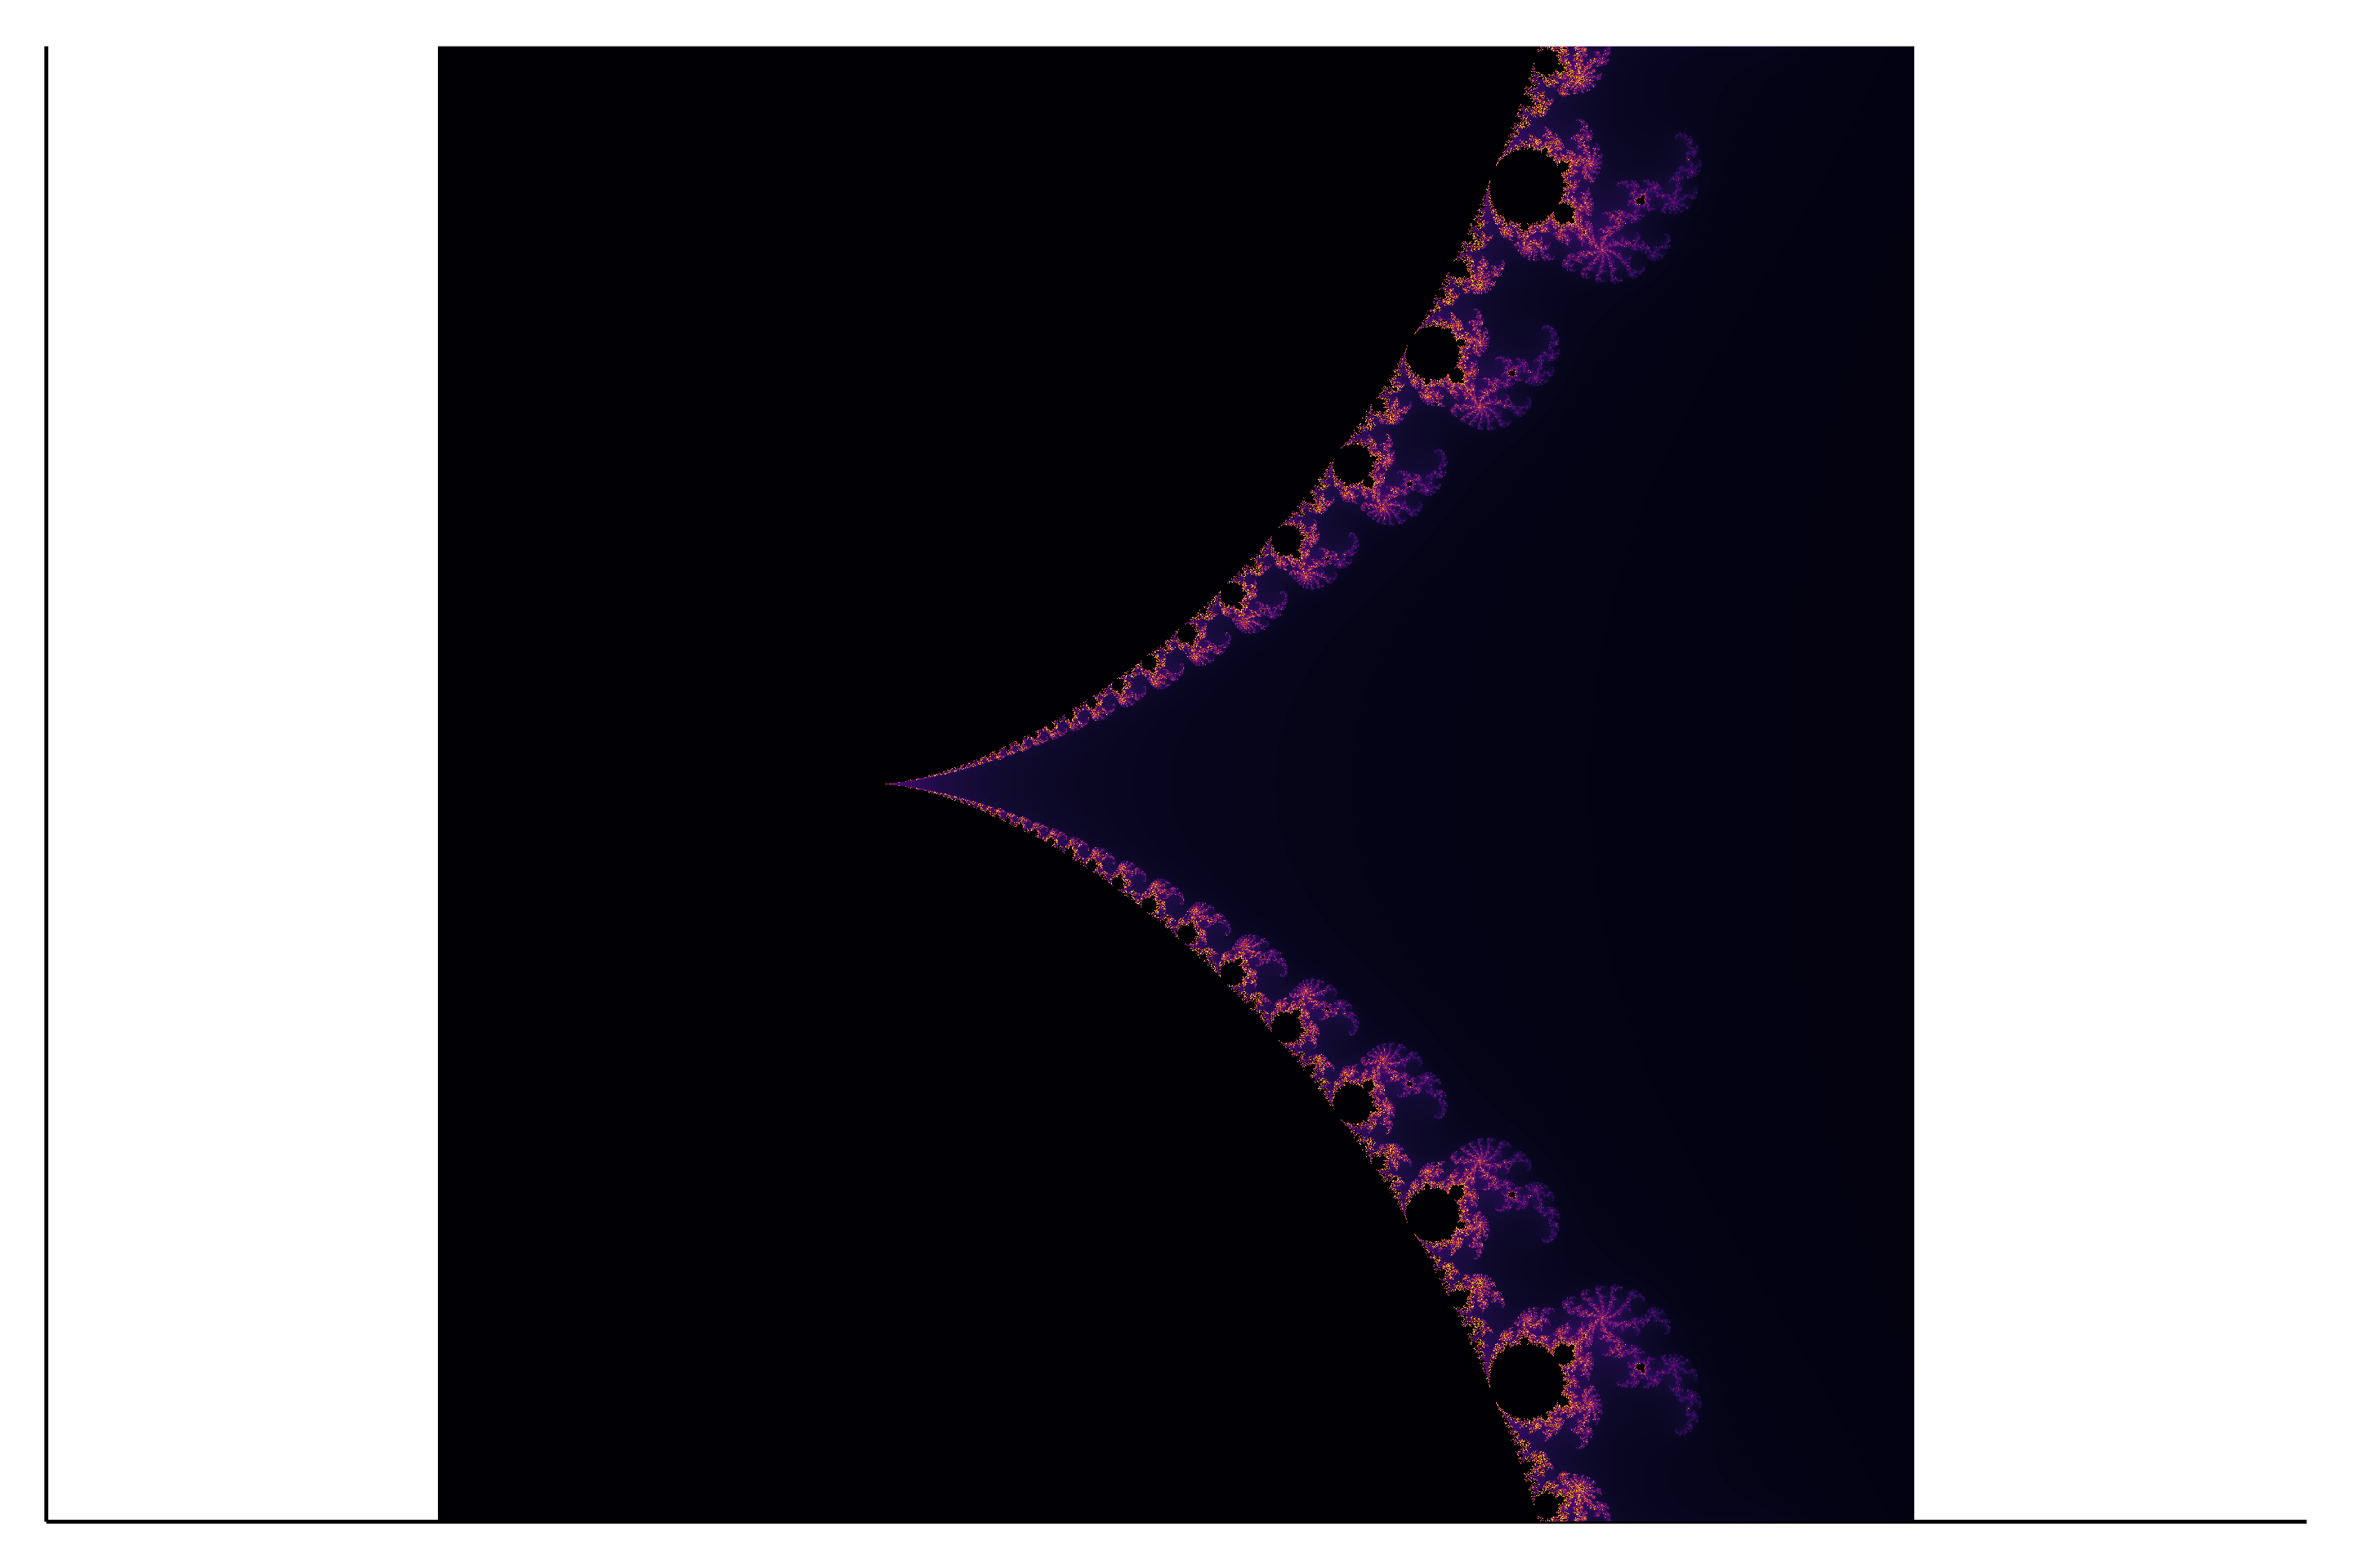

In [29]:
using Plots;
include("Mandelbrot.jl")
mandelbrot(0.30, 0.00)

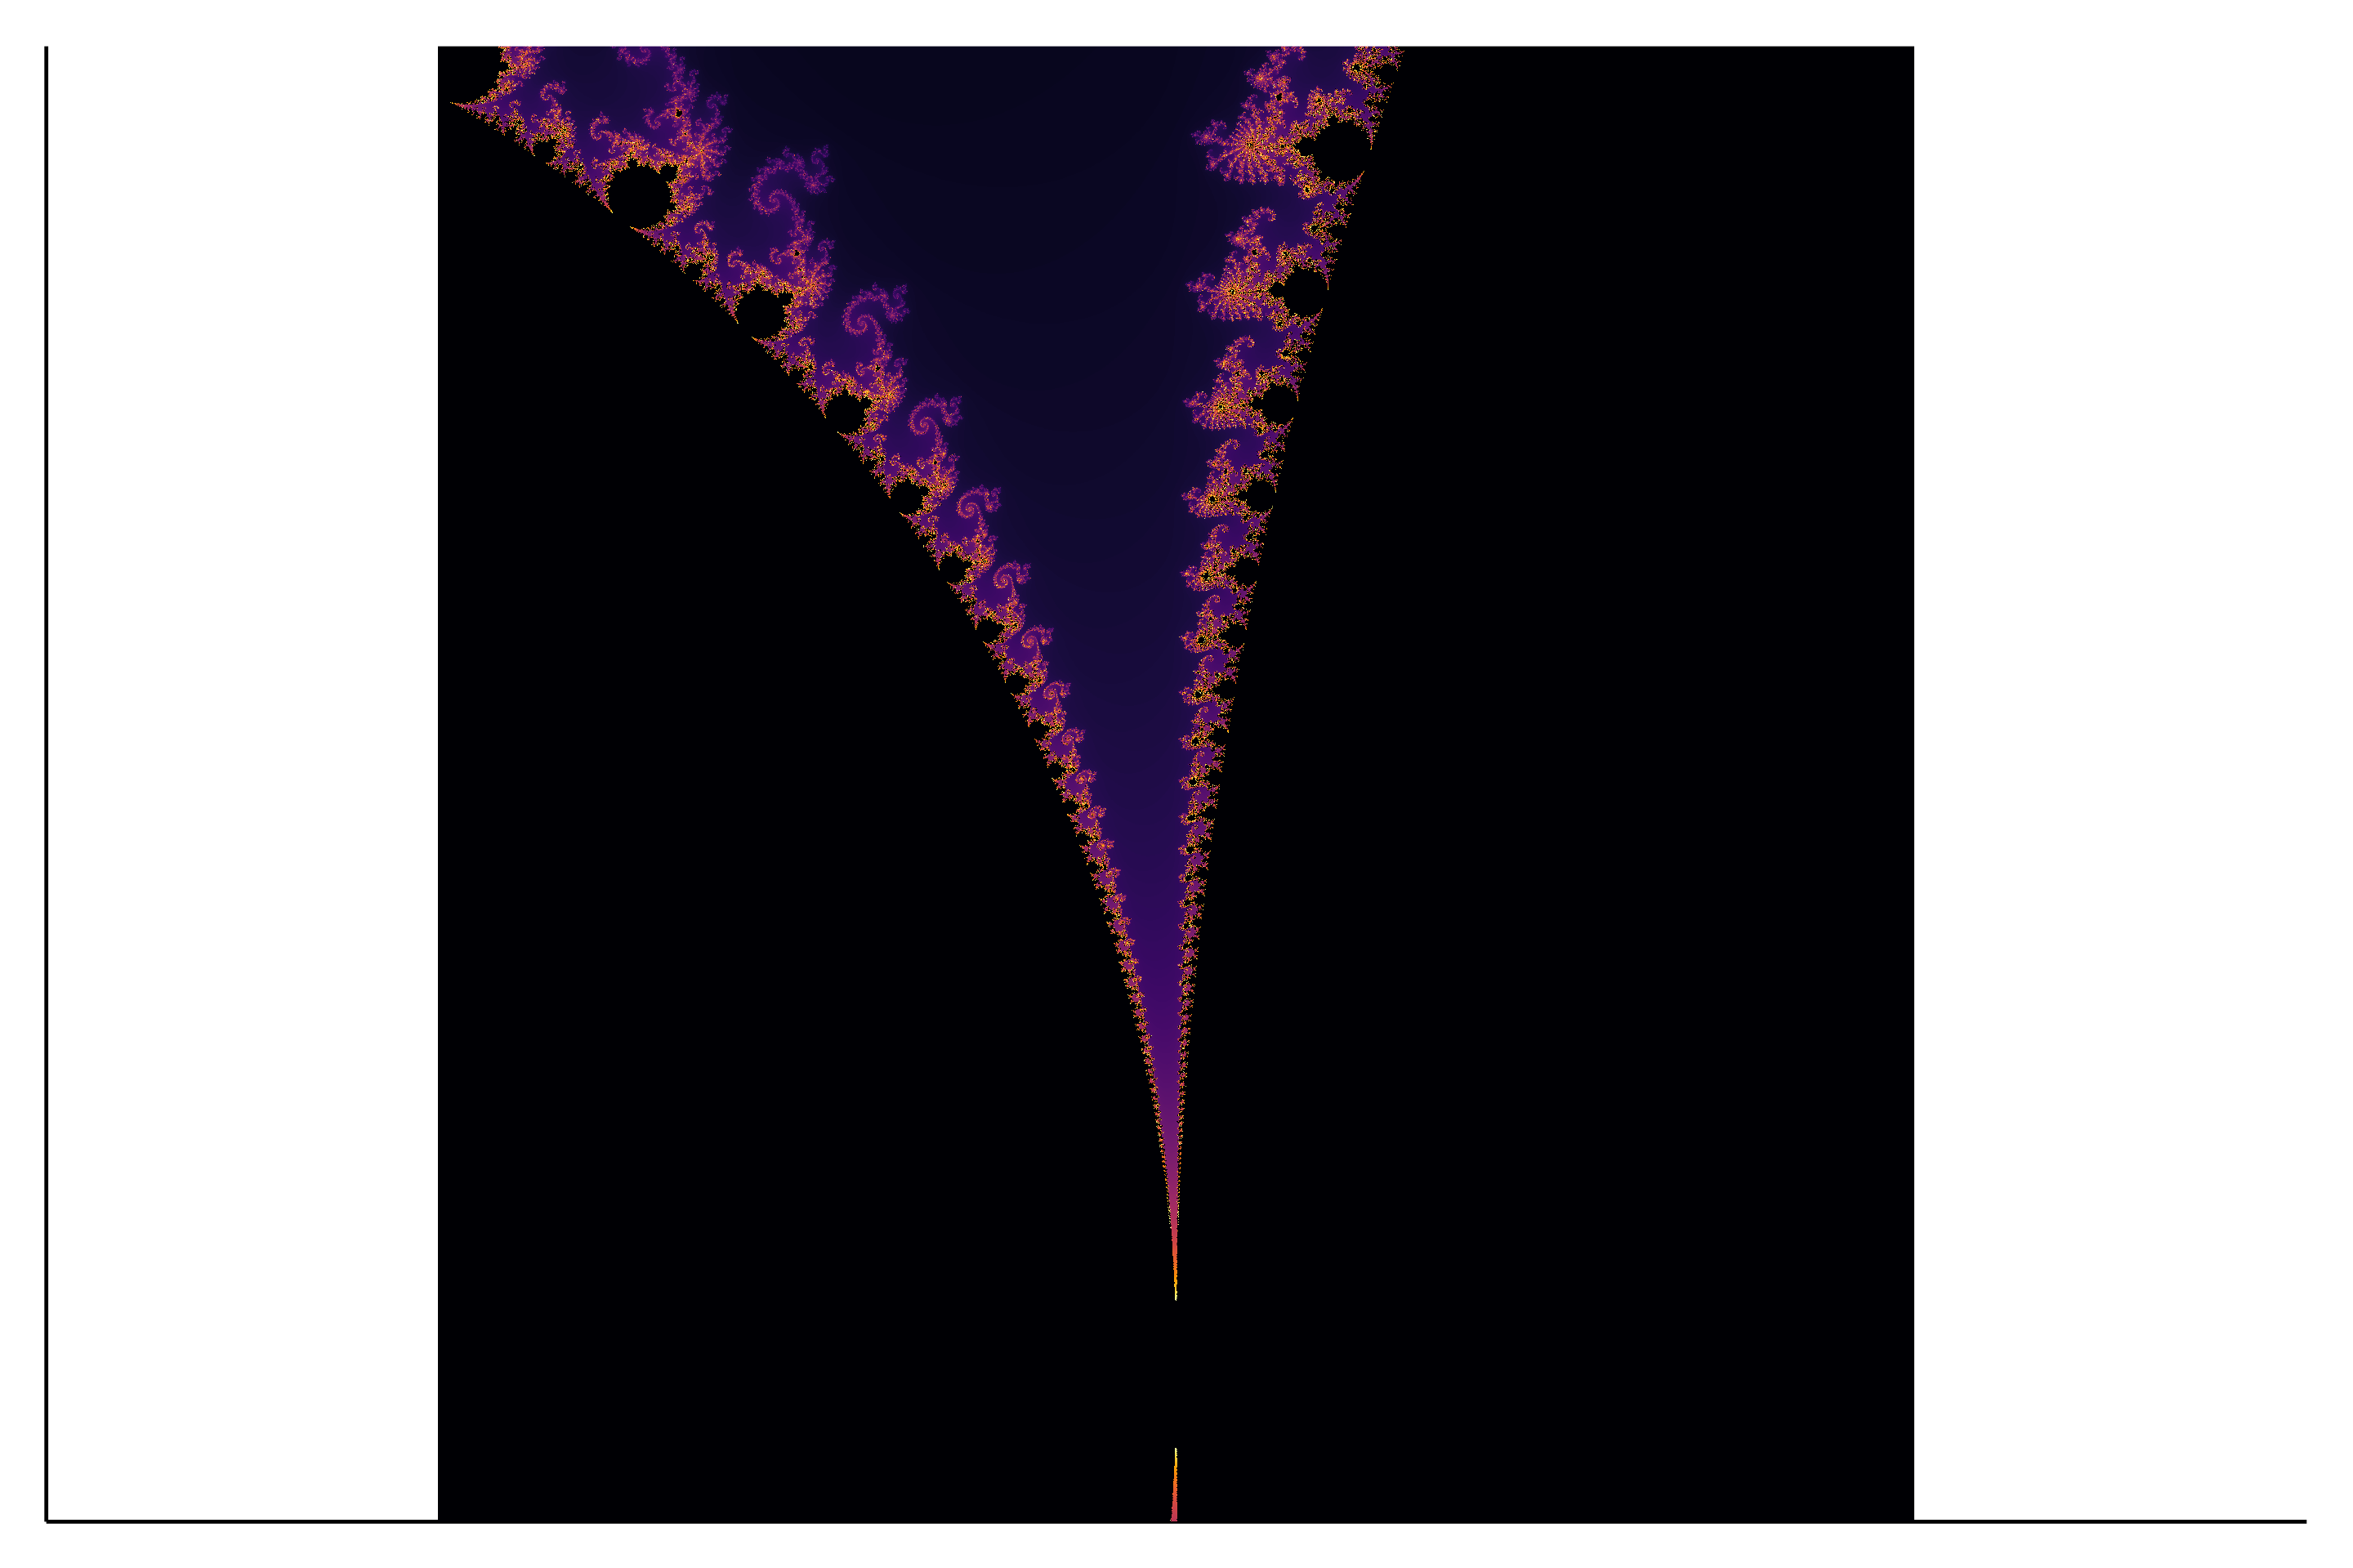

In [30]:
mandelbrot(-0.75, 0.10)

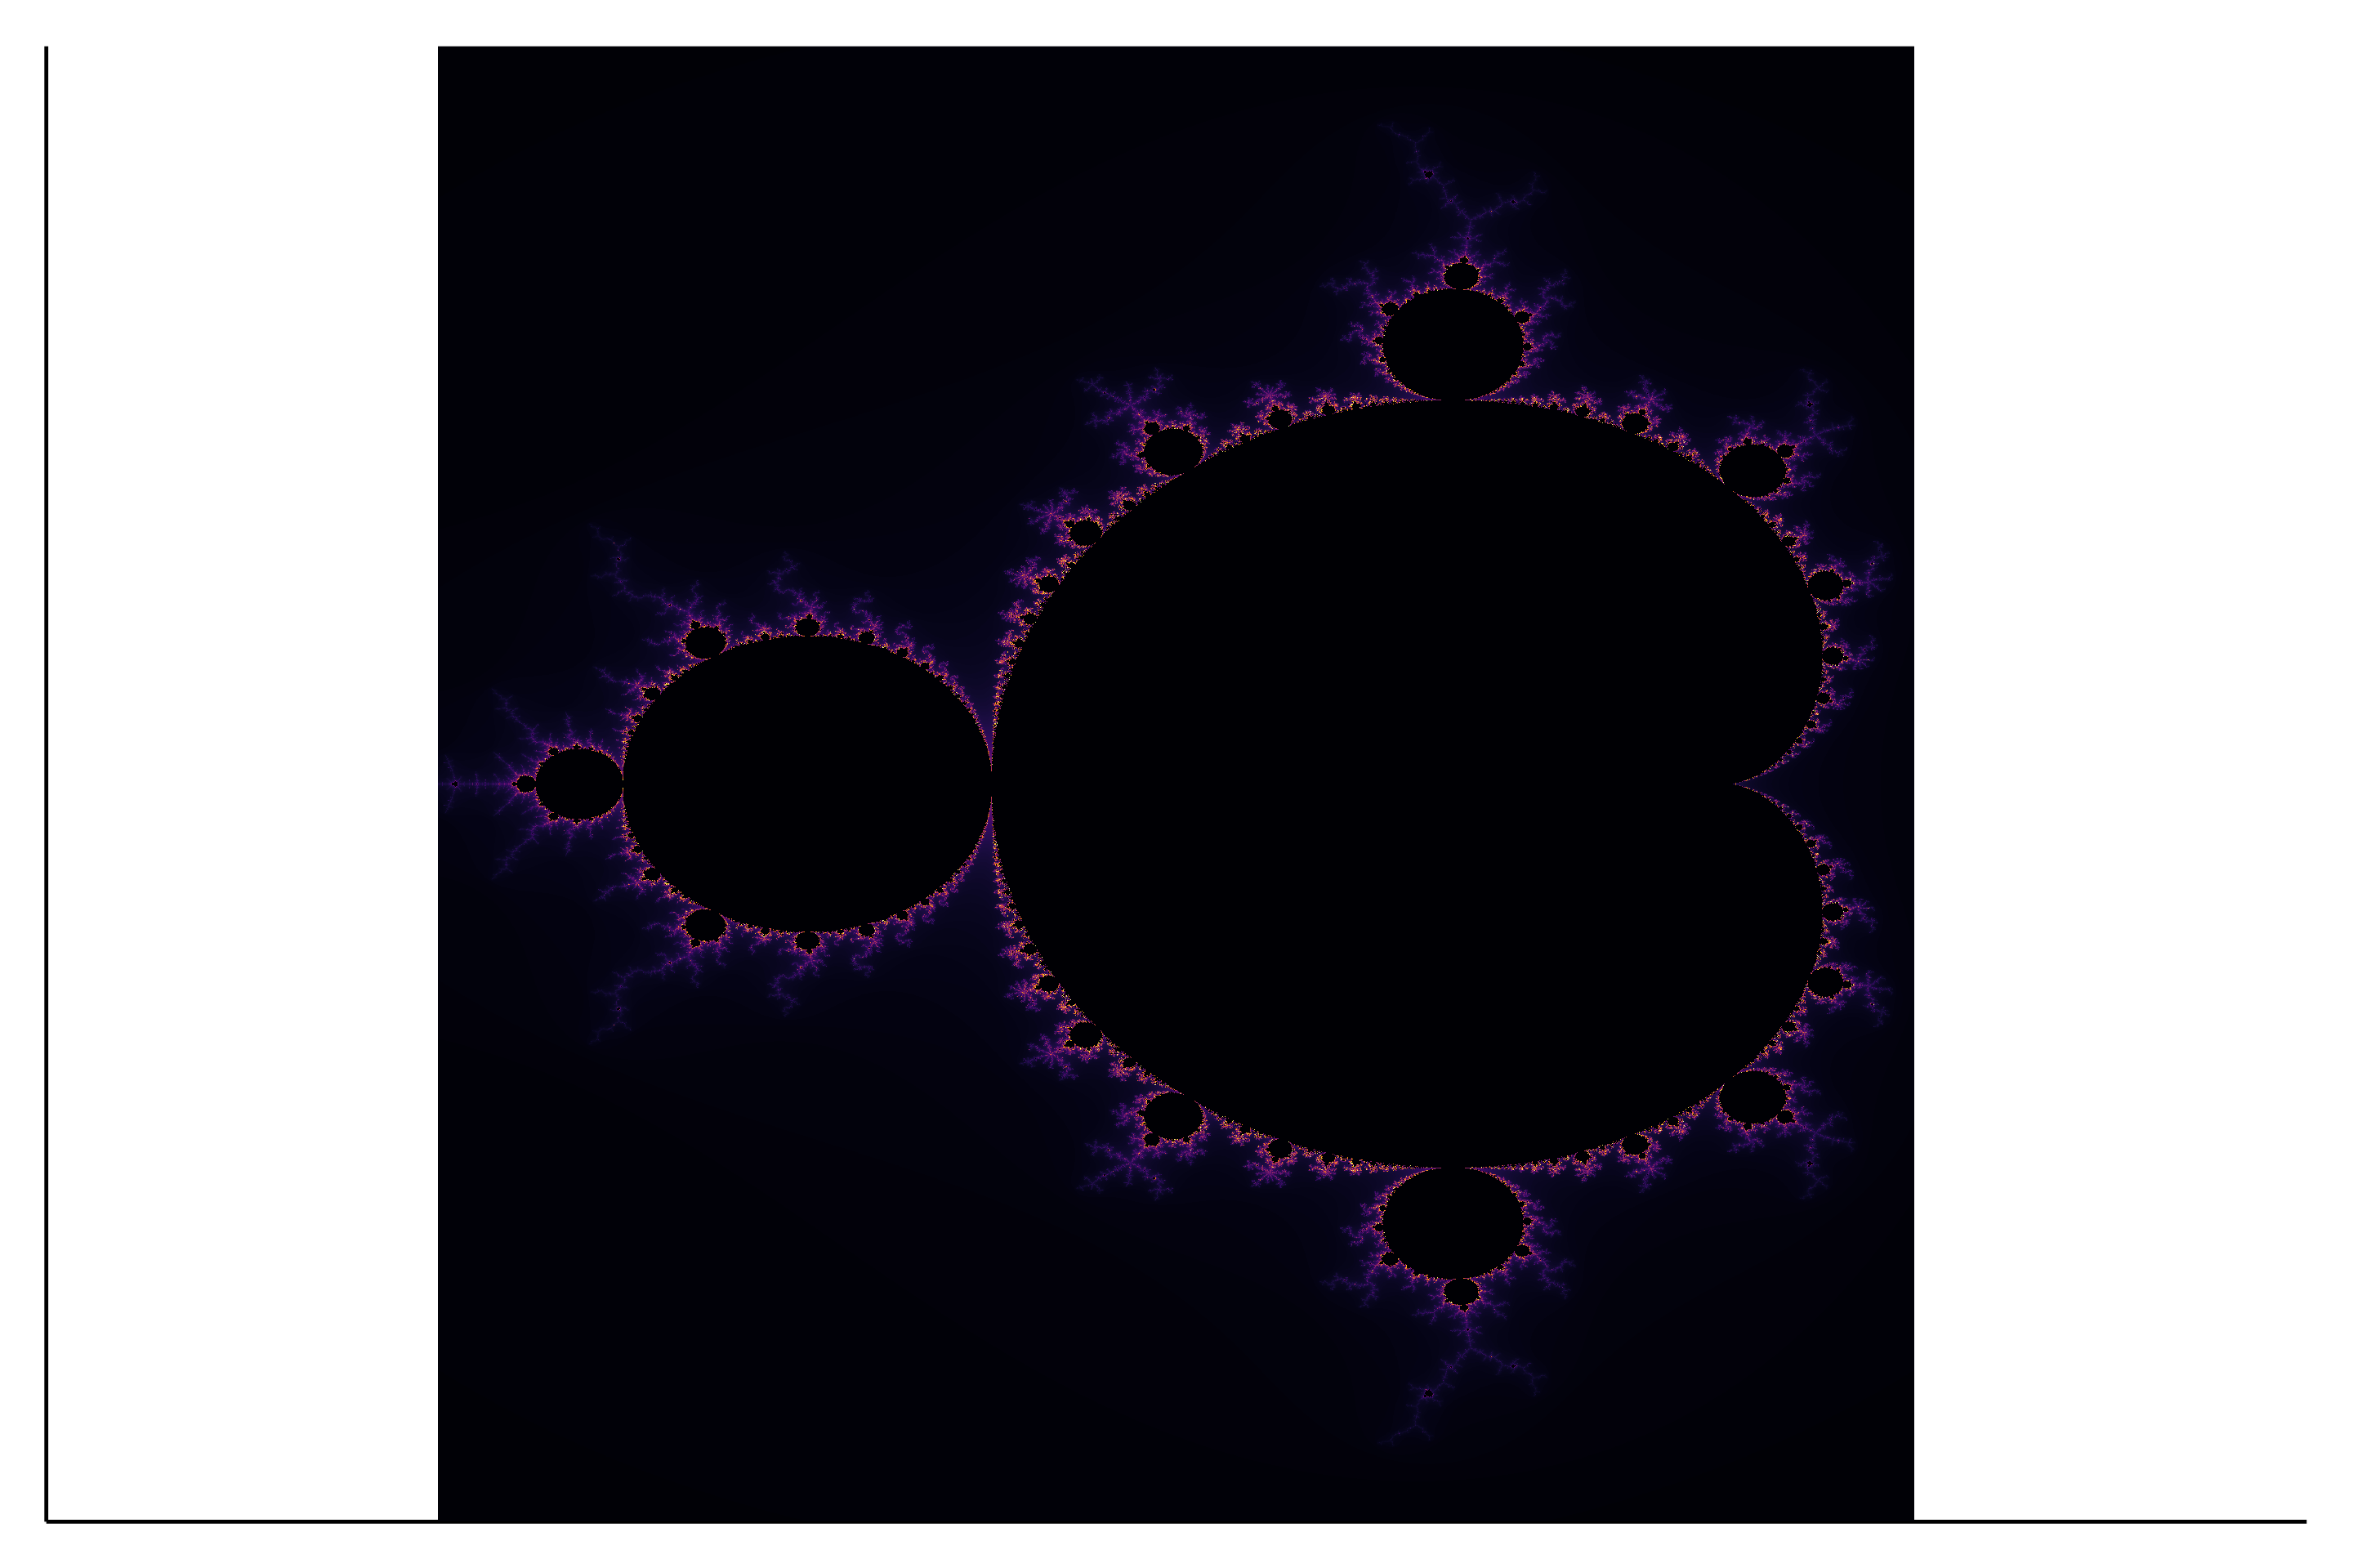

In [31]:
mandelbrot()

# KR 6 Time to plot the Mandelbrot Set

Let us now use the function ```@elapsed``` to know how long it takes for us to plot the Mandelbrot Set given the grid size ```n```. We do this for $n\in[2,1000]$. The code to do this is, and the resulting plot is shown as follows.

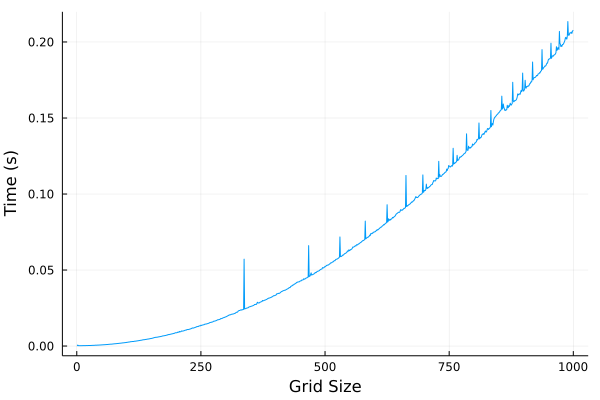

In [32]:
function get_time_elapsed(n)
    time_elapsed = zeros(Float64, n)
    for i=2:n
        time_elapsed[i] = @elapsed mandelbrot(0.00, 0.00, i)
    end
    return time_elapsed
end;

time_elapsed = get_time_elapsed(1000)
plot(time_elapsed, xlabel="Grid Size", ylabel="Time (s)", legend=false, fmt=:png)

# KR 7 Computational Complexity of ```Mandelbrot.jl```

Looking at the plot made in KR6, we see that ```Mandelbrot.jl``` has a time complexity of $\mathcal{O}(x^2)$ since the time it takes to plot the Mandelbrot Set with grid size ```n``` appears to be quadratic in nature. This makes sense because it takes time complexity $\mathcal{O}(x)$ to go through each axis of the grid, so that the total time complexity to go through the whole grid must be $\mathcal{O}(x)\cdot\mathcal{O}(x)=\mathcal{O}(x^2)$.

To be able to store this information into a vector to be plotted, we used the time macro ```@elapsed```, which works. Nice!